In [106]:
# Import necessary libraries
from pyorbital.orbital import Orbital
from datetime import datetime, timezone
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import csv
import random

In [107]:
file_name = r'C:\Users\danny\OneDrive\Desktop\Project\starlinkTLEs.txt'

# Function to read TLE data from a file
def read_tle_file(file_name):
    with open(file_name, 'r') as tle_file:
        lines = tle_file.readlines()
    return lines

# Function to calculate satellite altitude from TLE data
def get_satellite_altitude(tle_name, tle_line1, tle_line2):
    satellite = Orbital(tle_name, line1=tle_line1, line2=tle_line2)
    current_time = datetime.now(timezone.utc)
    _, _, alt = satellite.get_lonlatalt(current_time)
    return alt  # Altitude in km

# Function to calculate coverage area based on altitude and beamwidth
def calculate_coverage_area(altitude):
    R_f = altitude * np.tan(np.radians(22.5))  # Convert beamwidth to radius
    A = np.pi * R_f**2  # Area of the circular footprint
    return A

# Function to process all TLE data and calculate coverage for each satellite
def process_all_satellite_coverage(tle_data):
    satellite_coverage_data = []

    # Get current time once to avoid redundant calls
    current_time = datetime.now(timezone.utc)
    
    for i in range(0, len(tle_data), 3):
        tle_name = tle_data[i].strip()         # Satellite name
        tle_line1 = tle_data[i+1].strip()      # Line 1 of the TLE
        tle_line2 = tle_data[i+2].strip()      # Line 2 of the TLE
        
        try:
            # Get satellite altitude
            altitude = get_satellite_altitude(tle_name, tle_line1, tle_line2)
            
            # Calculate surface coverage area
            coverage_area = calculate_coverage_area(altitude)
            
            # Get latitude and longitude
            satellite = Orbital(tle_name, line1=tle_line1, line2=tle_line2)
            lon, lat, _ = satellite.get_lonlatalt(current_time)
            
            # Store satellite data and coverage area
            satellite_coverage_data.append({
                'name': tle_name,
                'latitude': lat,
                'longitude': lon,
                'altitude': altitude,
                'coverage_area': coverage_area
            })
        except Exception as e:
            # Skip satellites that have crashed or throw exceptions
            print(f"Error processing satellite {tle_name}: {e}")
            continue
    
    return satellite_coverage_data


In [108]:
# Function to process TLEs and remove satellites with 'DTC' in the name
def process_all_tles_filtered(tle_data):
    satellite_data = []
    
    current_time = datetime.now(timezone.utc)
    
    for i in range(0, len(tle_data), 3):
        tle_name = tle_data[i].strip()          # Satellite name
        
        # Skip if the satellite name contains 'DTC'
        if 'DTC' in tle_name:
            continue
        
        tle_line1 = tle_data[i+1].strip()       # Line 1 of the TLE
        tle_line2 = tle_data[i+2].strip()       # Line 2 of the TLE
        
        # Get satellite altitude
        altitude = get_satellite_altitude(tle_name, tle_line1, tle_line2)
        
        # Calculate surface coverage area
        coverage_area = calculate_coverage_area(altitude)
        
        # Get latitude and longitude
        satellite = Orbital(tle_name, line1=tle_line1, line2=tle_line2)
        lon, lat, _ = satellite.get_lonlatalt(current_time)
        
        # Store satellite data and coverage area
        satellite_data.append({
            'name': tle_name,
            'latitude': lat,
            'longitude': lon,
            'altitude': altitude,
            'coverage_area': coverage_area
        })
    
    return satellite_data

In [109]:
# Function to plot the satellite footprint on a map
def plot_satellite_coverage(satellite_data):
    # Create a Basemap instance for the world map
    m = Basemap(projection='ortho', lat_0=0, lon_0=0)  # Orthographic projection (looks like a globe)
    m.drawcoastlines()  # Draw coastlines
    m.drawcountries()  # Draw country boundaries
    m.fillcontinents(color='lightgray', lake_color='aqua')  # Fill continents
    m.drawmapboundary(fill_color='aqua')  # Background color for the ocean

    # Loop through each satellite and plot its coverage
    for satellite in satellite_data:
        lat = satellite['latitude']
        lon = satellite['longitude']
        coverage_radius = np.sqrt(satellite['coverage_area'] / np.pi)  # Convert area to radius
        
        # Convert latitude and longitude to map projection coordinates
        x, y = m(lon, lat)
        
        # Plot the satellite's position
        m.scatter(x, y, color='red', marker='o', s=5, alpha =0.5, label=f"{satellite['name']}")

        # Plot the coverage area as a circle around the satellite
        coverage_circle = plt.Circle((x, y), coverage_radius * 1000, color='black', fill=False, linestyle='--', linewidth=1, alpha =0.4)
        plt.gca().add_patch(coverage_circle)
    ,5,
    # Add title and show the map
    plt.title('Satellite Coverage Area on World Map')
    plt.show()

In [110]:
# Function to save satellite coverage data to a CSV file
def save_coverage_to_csv(satellite_coverage_data, output_file_name):
    with open(output_file_name, 'w', newline='') as csvfile:
        fieldnames = ['Satellite', 'Latitude', 'Longitude', 'Altitude (km)', 'Coverage Area (km^2)']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()  # Write CSV header
        
        # Write data for each satellite
        for satellite in satellite_coverage_data:
            writer.writerow({
                'Satellite': satellite['name'],
                'Latitude': satellite['latitude'],
                'Longitude': satellite['longitude'],
                'Altitude (km)': satellite['altitude'],
                'Coverage Area (km^2)': satellite['coverage_area']
            })
    
    print(f"Satellite coverage data saved to {output_file_name}")

Error processing satellite STARLINK-1455: ('Satellite crashed at time %s', numpy.datetime64('2024-10-07T12:56:38.579582'))


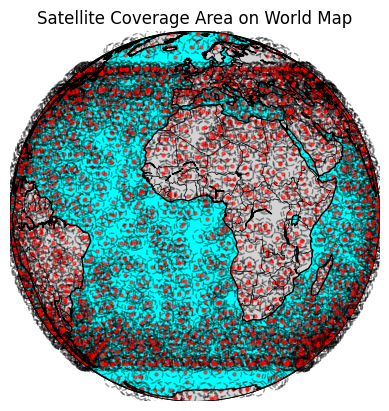

Satellite coverage data saved to satellite_coverage.csv


In [111]:
# Step 1: Read the TLE file
tle_data = read_tle_file(file_name)

# Step 2: Process the TLE data to get satellite coverage information
satellite_coverage_data = process_all_satellite_coverage(tle_data)

# Step 3: Plot the coverage for these satellites
plot_satellite_coverage(satellite_coverage_data)

# Step 4: Save the satellite coverage data to CSV
output_file_name = 'satellite_coverage.csv'
save_coverage_to_csv(satellite_coverage_data, output_file_name)